In [74]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import random
from skimage.measure import compare_ssim as ssim
from sklearn.metrics import mean_squared_error as mse
import importlib
import Scripts.autoencoder as ae
import Scripts.wake_processing as wp

In [91]:
importlib.reload(ae)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'C:\\Users\\Igor\\Desktop\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

## Reading data

In [86]:
data_series = wp.get_files()

In [92]:
## Fixing shifted wake time stamps in data
# Special cases - no data - ignored
# ws:  2094960
# ws:  2418060
wake_start = wp.get_wakes()
new_ws = wake_start
for ws in wake_start:
    if ws not in set(data_series[0,-1,:]):
        if ws-12 in set(data_series[0,-1,:]):
            new_ws = np.append(new_ws, ws-12)

## Train/test split

In [93]:
# 22 to 25 September for the test set.
cutoff = np.where(data_series[0,-1:]<wp.date_to_stamp([9, 22, 0, 0]))[1][-1]
train_data_series = data_series[:,:,:cutoff]
test_data_series = data_series[:,:,cutoff:]

In [83]:
wake_samples = wp.frames_by_timestamps(train_data_series, new_ws)

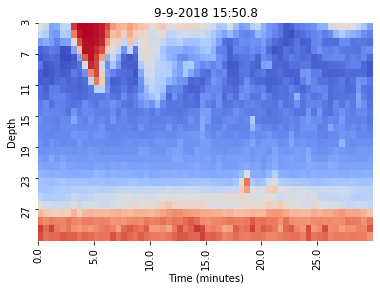

In [95]:
wp.make_heatmap(wake_samples[141,3,:-1,:], wake_samples[141,3,-1,:])

## CNN autoencoder

In [25]:
model = None
model = ae.Autoencoder()
model.double()
epochs = 50
outputs = ae.train_autoencoder(model, wake_samples[:,:,:-1,:], num_epochs=epochs, batch_size = 5)

Epoch:1, Loss:0.0059
Epoch:2, Loss:0.0081
Epoch:3, Loss:0.0055
Epoch:4, Loss:0.0045
Epoch:5, Loss:0.0060
Epoch:6, Loss:0.0038
Epoch:7, Loss:0.0057
Epoch:8, Loss:0.0029
Epoch:9, Loss:0.0039
Epoch:10, Loss:0.0056
Epoch:11, Loss:0.0019
Epoch:12, Loss:0.0027
Epoch:13, Loss:0.0045
Epoch:14, Loss:0.0040
Epoch:15, Loss:0.0029
Epoch:16, Loss:0.0022
Epoch:17, Loss:0.0017
Epoch:18, Loss:0.0042
Epoch:19, Loss:0.0022
Epoch:20, Loss:0.0025
Epoch:21, Loss:0.0026
Epoch:22, Loss:0.0015
Epoch:23, Loss:0.0019
Epoch:24, Loss:0.0022
Epoch:25, Loss:0.0020
Epoch:26, Loss:0.0018
Epoch:27, Loss:0.0012
Epoch:28, Loss:0.0023
Epoch:29, Loss:0.0025
Epoch:30, Loss:0.0024
Epoch:31, Loss:0.0018
Epoch:32, Loss:0.0021
Epoch:33, Loss:0.0018
Epoch:34, Loss:0.0019
Epoch:35, Loss:0.0019
Epoch:36, Loss:0.0011
Epoch:37, Loss:0.0016
Epoch:38, Loss:0.0018
Epoch:39, Loss:0.0019
Epoch:40, Loss:0.0020
Epoch:41, Loss:0.0013
Epoch:42, Loss:0.0018
Epoch:43, Loss:0.0011
Epoch:44, Loss:0.0017
Epoch:45, Loss:0.0015
Epoch:46, Loss:0.00

In [34]:
test_reconst = ae.test_reconstruction(model, wake_samples[17,:,:-1,:])

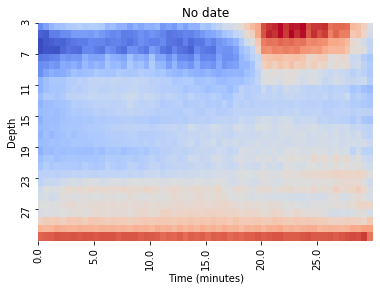

In [43]:
make_heatmap(test_reconst[3], None)

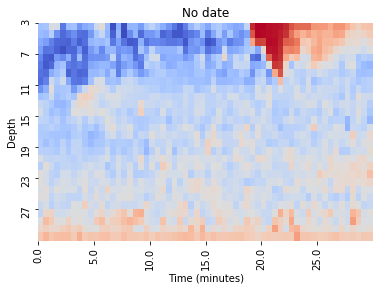

In [44]:
make_heatmap(wake_samples[17,3,:-1,:], None)

## Positive samples with GMM and CNN

In [64]:
compressed_wakes = ae.compress_wakes(wake_samples, model)

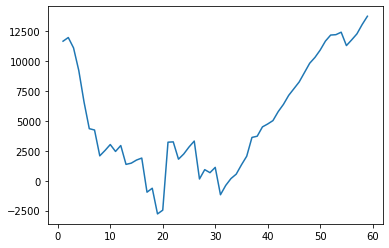

In [66]:
gmm_cnn_data = np.array([w.flatten() for w in compressed_wakes])
pca_cnn = PCA(0.999, whiten=True)
data_cnn = pca_cnn.fit_transform(gmm_cnn_data)
n_components = np.arange(1, 60)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data_cnn).aic(data_cnn) for model in models]
plt.plot(n_components, aics)
plt.show()

In [67]:
gmm_cnn = GMM(19, covariance_type='full', random_state=44)
gmm_cnn.fit(data_cnn)
cnn_pca_seeds = gmm_cnn.sample(100)
cnn_seeds = pca_cnn.inverse_transform(cnn_pca_seeds[0])

In [68]:
decompressed_wakes = ae.decompress_wakes(cnn_seeds, model)

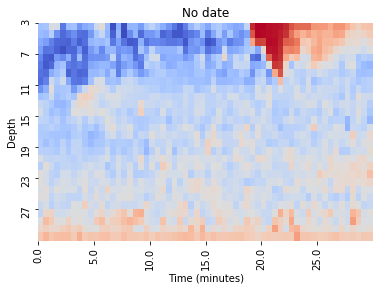

In [77]:
wp.make_heatmap(wake_samples[17,3,:-1,:], None)

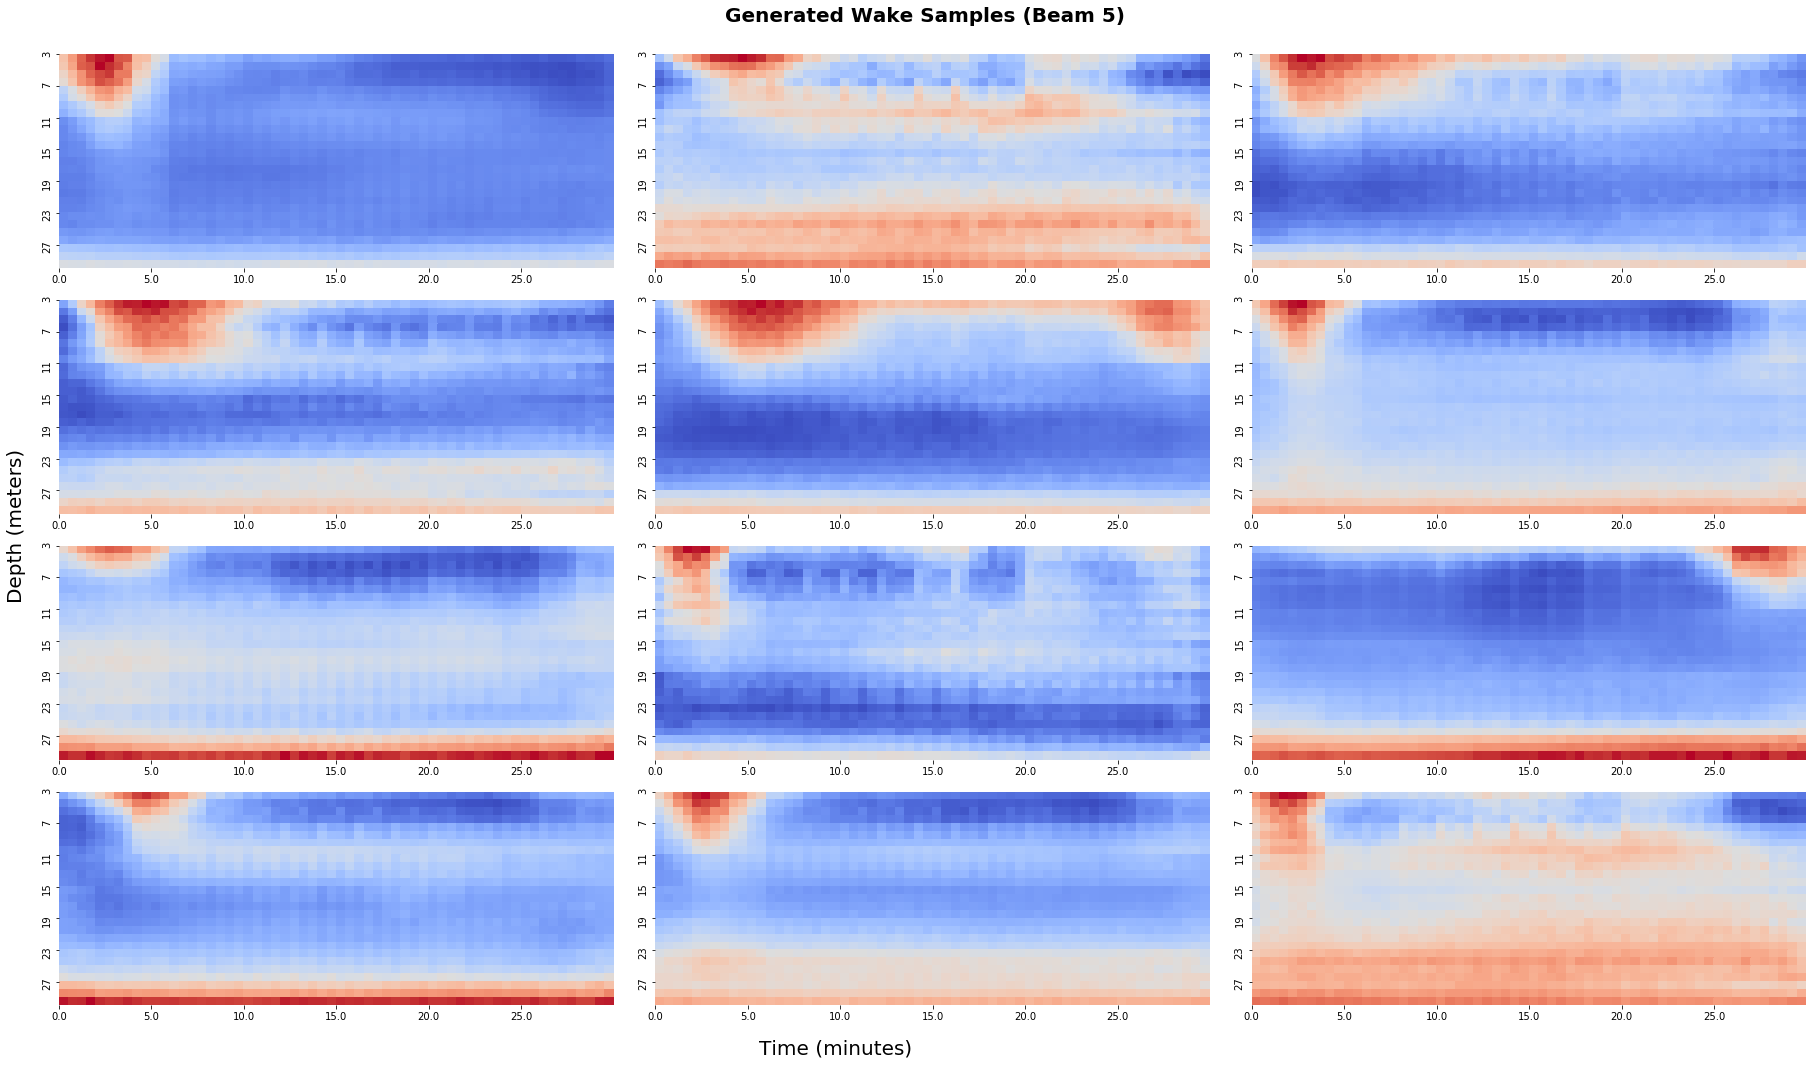

In [70]:
make_12_heatmaps(decompressed_wakes[36:48,3, :-1, :], title =  'Generated Wake Samples (Beam 5)')

## Making negative samples

In [88]:
train_data_series.shape

(4, 29, 69182)

In [49]:
neg_ind = set(np.arange(train_data_series.shape[2] - 60))

In [50]:
for ws in new_ws:
    for i in range(15):
        neg_ind.discard(ws-i)
        neg_ind.discard(ws+i)

In [51]:
rand_fs = np.array(random.sample(neg_ind, 100))

In [52]:
neg_samples = []
for fs in rand_fs:
    neg_samples.append(data_series[:,:, fs:fs+60])

In [53]:
neg_samples = np.array(neg_samples)

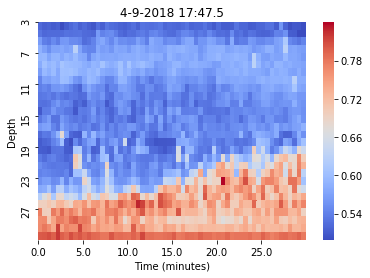

In [54]:
make_heatmap(neg_samples[5,3,:-1], neg_samples[5, 3,-1])

## Structural similaruty index

In [58]:
ssim_total = 0
mse_total = 0
for w1 in wake_samples[:,:,:-1,:]:
    for w2 in wake_samples[:,:,:-1,:]:
        for i in range(4):
            ssim_total+=ssim(w1[i,:-1], w2[i,:-1])
            mse_total +=mse(w1[i,:-1], w2[i,:-1])
print('Average ssim:', ssim_total/(4*wake_samples.shape[0]**2))
print('Average mse:', mse_total/(4*wake_samples.shape[0]**2))

Average ssim: 0.6406112707474159
Average mse: 0.009911401301727268


In [89]:
ssim_total = 0
mse_total = 0
for w1 in wake_samples[:,:,:-1,:]:
    for w2 in decompressed_wakes:
        for i in range(4):
            ssim_total+=ssim(w1[i,:-1], w2[i,:-1])
            mse_total +=mse(w1[i,:-1], w2[i,:-1])
print('Average ssim generated vs. real wakes:', ssim_total/(4*wake_samples.shape[0]*decompressed_wakes.shape[0]))
print('Average mse generated vs. real wakes:', mse_total/(4*wake_samples.shape[0]*decompressed_wakes.shape[0]))

Average ssim generated vs. real wakes: 0.742019613396139
Average mse generated vs. real wakes: 0.008123718490199905


In [103]:
w_total = 0
for w1 in wake_samples[:,:,:-1,:]:
    for w2 in decompressed_wakes:
        for i in range(4):
            w_total+=w_dist(w1[i,:-1].flatten(), w2[i,:-1].flatten())
print('Average wasserstein distance generated vs. real wakes:', w_total/(4*wake_samples.shape[0]*decompressed_wakes.shape[0]))

Average wasserstein distance generated vs. real wakes: 0.05264261361529561


In [90]:
ssim_total = 0
mse_total = 0
for w1 in neg_samples[:,:,:-1,:]:
    for w2 in decompressed_wakes:
        for i in range(4):
            ssim_total+=ssim(w1[i,:-1], w2[i,:-1])
            mse_total +=mse(w1[i,:-1], w2[i,:-1])
print('Average ssim generated vs. random frames:', ssim_total/(4*neg_samples.shape[0]*decompressed_wakes.shape[0]))
print('Average mse generated vs. random frames:', mse_total/(4*neg_samples.shape[0]*decompressed_wakes.shape[0]))

Average ssim generated vs. random frames: 0.7531760888799356
Average mse generated vs. random frames: 0.0077838013512961214


In [94]:
from scipy.stats import wasserstein_distance as w_dist

In [101]:
w_total = 0
for w1 in neg_samples[:,:,:-1,:]:
    for w2 in decompressed_wakes:
        for i in range(4):
            w_total+=w_dist(w1[i,:-1].flatten(), w2[i,:-1].flatten())
print('Average wasserstein distance generated vs. random frames:', w_total/(4*neg_samples.shape[0]*decompressed_wakes.shape[0]))

Average wasserstein distance generated vs. random frames: 0.054311832316778816


In [61]:
ssim_total = 0
mse_total = 0
for w1 in wake_samples[:,:,:-1,:]:
    for w2 in neg_samples[:,:,:-1,:]:
        for i in range(4):
            ssim_total+=ssim(w1[i,:-1], w2[i,:-1])
            mse_total +=mse(w1[i,:-1], w2[i,:-1])
print('Average ssim random frames vs. real wakes:', ssim_total/(4*wake_samples.shape[0]*neg_samples.shape[0]))
print('Average mse random frames vs. real wakes:', mse_total/(4*wake_samples.shape[0]*neg_samples.shape[0]))

Average ssim random frames vs. real wakes: 0.6482471058939391
Average mse random frames vs. real wakes: 0.009729305656470531


In [102]:
w_total = 0
for w1 in wake_samples[:,:,:-1,:]:
    for w2 in neg_samples[:,:,:-1,:]:
        for i in range(4):
            w_total+=w_dist(w1[i,:-1].flatten(), w2[i,:-1].flatten())
print('Average wasserstein distance random frames vs. real wakes:', w_total/(4*wake_samples.shape[0]*neg_samples.shape[0]))

Average wasserstein distance random frames vs. real wakes: 0.05442177151385353
